In [45]:

import os
import sys
import json
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import motornet as mn
import utils
import agents
from importlib import reload
reload(agents)
reload(utils)
from utils import load_env, load_policy, calc_loss, run_rollout
from model import run_episode
from task import CentreOutFF
from agents import SLAgent
# from sb3_contrib import RecurrentPPO


In [41]:
# effector = mn.effector.RigidTendonArm26(muscle=mn.muscle.RigidTendonHillMuscle())
# env = mn.environment.RandomTargetReach(effector=effector, max_ep_duration=1.)
env = load_env(CentreOutFF)
n_input = env.observation_space.shape[0]
n_output = env.n_muscles
policy, optimizer, scheduler = load_policy(n_input,n_output,phase='growing_up')




Batch 0, Loss: 188.01666259765625
Batch 10, Loss: 231.68026275634764
Batch 20, Loss: 250.99559020996094


KeyboardInterrupt: 

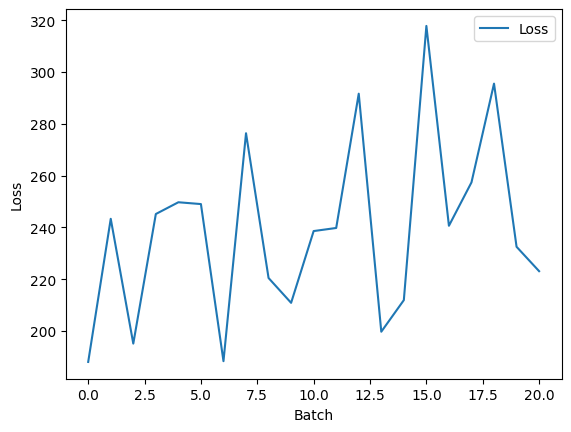

In [ ]:
batch_size = 32
n_batch = 1000
losses = []
interval = 10
device = th.device("cuda" if th.cuda.is_available() else "cpu")

for batch in range(n_batch):
    agent = SLAgent(obs_dim=n_input, action_dim=n_output)
    data = run_rollout(env, agent, batch_size=batch_size)
    loss = agent.update(data)
    losses.append(loss)

    if batch % interval == 0:
        print(f"Batch {batch}, Loss: {np.mean(losses[-interval:])}")
        # plt.plot(losses)
        # plt.show()

In [ ]:
batch_size = 32
n_batch = 1000
losses = []
interval = 10

for batch in range(n_batch):
    data = run_episode(env, policy, batch_size=batch_size, ff_coefficient=0)
    overall_loss = calc_loss(data, loss_weight=None) # [1e+3,1e+5,1e-1,3e-4,1e-5,1e-3,0]
    # backward pass & update weights
    optimizer.zero_grad() 
    overall_loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
    optimizer.step()
    losses.append(overall_loss.item())

    if (batch % interval == 0) and (batch != 0):
        print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))



In [40]:
batch_size = 32
n_batch = 1000
losses = []
interval = 10


def l1(x, y):
  """L1 loss"""
  return th.mean(th.sum(th.abs(x - y), dim=-1))

for batch in range(n_batch):
    h = policy.init_hidden(batch_size = batch_size)
    obs, info = env.reset(options={'batch_size':batch_size})
    terminated = False

    # initial poisitions and targets
    xy = [info["states"]["fingertip"][:, None, :]]
    tg = [info["goal"][:, None, :]]

    # simulate whole episode
    while not terminated:  # will run until `max_ep_duration` is reached
        action, h = policy(obs, h)
        obs, terminated, info = env.step(action=action)

        xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
        tg.append(info["goal"][:, None, :])  # targets

    # concatenate into a (batch_size, n_timesteps, xy) tensor
    xy = th.cat(xy, axis=1)
    tg = th.cat(tg, axis=1)
    # loss = calc_loss()
    loss = l1(xy, tg)

        # backward pass & update weights
    optimizer.zero_grad() 
    loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
    optimizer.step()
    losses.append(loss.item())

    if (batch % interval == 0) and (batch != 0):
        print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))

    

Batch 10/1000 Done, mean policy loss: 0.22079749554395675
Batch 20/1000 Done, mean policy loss: 0.20228872448205948
Batch 30/1000 Done, mean policy loss: 0.1795849546790123
Batch 40/1000 Done, mean policy loss: 0.17905158698558807
Batch 50/1000 Done, mean policy loss: 0.18864884376525878
Batch 60/1000 Done, mean policy loss: 0.1743134081363678
Batch 70/1000 Done, mean policy loss: 0.16410528719425202
Batch 80/1000 Done, mean policy loss: 0.1467793956398964
Batch 90/1000 Done, mean policy loss: 0.15351783782243728
Batch 100/1000 Done, mean policy loss: 0.15058071538805962
Batch 110/1000 Done, mean policy loss: 0.13508556559681892
Batch 120/1000 Done, mean policy loss: 0.13054453805088997
Batch 130/1000 Done, mean policy loss: 0.1418978191912174
Batch 140/1000 Done, mean policy loss: 0.13029820770025252
Batch 150/1000 Done, mean policy loss: 0.125131693482399
Batch 160/1000 Done, mean policy loss: 0.12053677961230277
Batch 170/1000 Done, mean policy loss: 0.11072440147399902
Batch 180/10

In [49]:
xy.shape, tg.shape

(torch.Size([32, 101, 2]), torch.Size([32, 101, 2]))

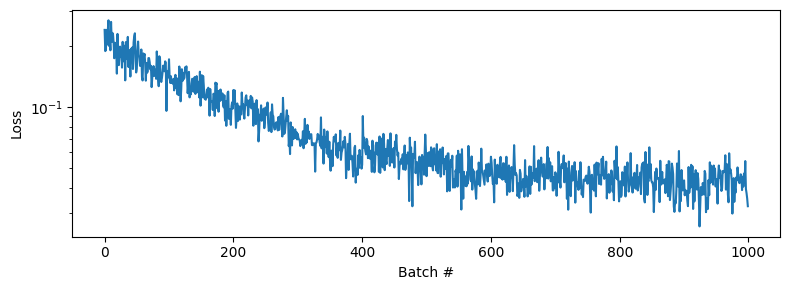

In [46]:
def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  axs.semilogy(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(losses)

In [55]:
from plot import plot_simulations

IndexError: list index out of range

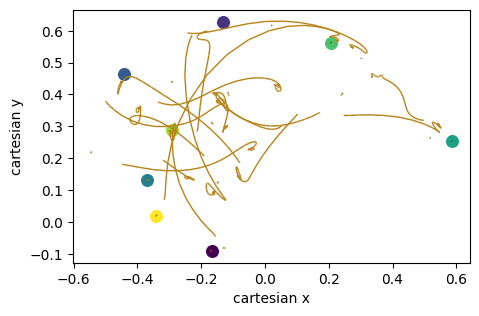

In [58]:
fg, ax = plt.subplots(nrows=1,ncols=1)
plot_simulations(ax,xy=th.detach(xy),target_xy=th.detach(tg))


In [62]:
plotor = mn.plotor.plot_pos_over_time

def plot_simulations2(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.ylim([-.4, 0.6])
  plt.xlim([-0.6, 0.6])
  plotor(axis=plt.gca(), cart_results=xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  plt.ylim([-2, 2])
  plt.xlim([-2, 2])
  plotor(axis=plt.gca(), cart_results=xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  plt.show()


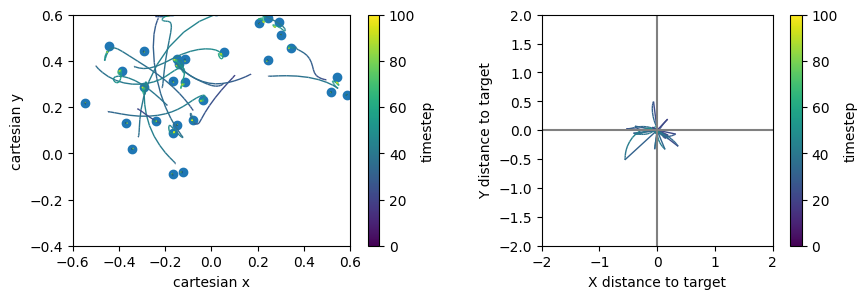

In [63]:
plot_simulations2(xy = th.detach(xy), target_xy=th.detach(tg))

done.


In [ ]:
timestep = 0.01
muscle_name = 'RigidTendonHillMuscle'  # or 'HillMuscle'
muscle = getattr(mn.muscle,muscle_name)()
effector = mn.effector.RigidTendonArm26(muscle=muscle,timestep=timestep) 

from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv
# vectorized env 구성
# RecurrentPPO 모델 생성
# vec_env = DummyVecEnv([lambda: env])  # DummyVecEnv는 단일 환경을 벡터화하는 데 사용됩니다.
num_envs = 3
# vec_env = DummyVecEnv([lambda: SB3CentreOutFF(timestep=0.01, muscle_name='RigidTendonHillMuscle',
#                                               condition='train', is_channel=True) 
#                        for _ in range(num_envs)])
vec_env = DummyVecEnv([lambda: SB3CentreOutFF(timestep=0.01, muscle_name='RigidTendonHillMuscle', condition='train', is_channel=True ) for _ in range(num_envs)])

model = RecurrentPPO("MlpLstmPolicy", vec_env, verbose=1,
                    #  tensorboard_log="./sb3_recurrent_tensorboard/",
                     learning_rate=3e-4,
                     n_steps=128,    # on-policy rollout 길이. 환경 특성에 맞게 조정
                     batch_size=64,
                     n_epochs=10,
                     gamma=0.99,
                     clip_range=0.2)
model.learn(total_timesteps=200_000)
model.save("recurrent_ppo_centreout")
